In [2]:
import numpy as np
import cv2
from scipy import misc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import os
import medpy
from medpy.io import load
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage #, correlation_layer, meanfield
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d, deeds2d

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# Data
Load data and split into train and test set

In [3]:
imgs = torch.load('Data/img.pth')
segs = torch.load('Data/seg.pth')

In [4]:
H,W = imgs[0].shape

In [5]:
#define a training split 
torch.manual_seed(10)
# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 39])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]
print("Train: ", train_set)
print("Test: ", test_set)

Train:  tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38,
        40, 42])
Test:  tensor([35, 41,  0,  4, 39])


# Networks

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features

OBELISK2d(
  (layer0): Conv2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1))
)

In [43]:
# initalize the sequential used for comparisson
# The output will be used later with the correlation layer and the meanfield inference
seq = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,24,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())

In [9]:
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    # 1) switch dimensions in order to get per HW position the displacement with "highest correlation" by
    # means of lowest SSD 
    # therefore, swap the dimensions of the tensor in order to make the pooling operations work along the 
    # displacement search region: [1,121,80,64] -> [1,80,64,121] -> [1,80*64,11,11] = [1,5120,11,11]
    # using appropriate padding, -max(-x) u get the min value and 2x avg-pooling afterwards for quadratic smoothing
    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    # 2)reconstruct the spatial arangement [1,121,80,78] and perform the spatial mean-field inference under valid padding
    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

# meanfield converts 4D tensor with SSD distance cost (of all displacements) into regularised probabilistic field
def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device


    cost = min_convolution(ssd_distance, displace_range, H, W)

    # probabilistic output: compute the contributions weights of every discrete displacement pair for all positions
    # along 121 possible xy displacements -> normalize to [0,1] with softmax:
    # in order to have the lowest SSD value as the "max" 1 value, multiply it with -10 beforehand

    # therefore apply the softmax along the displacement dimension
    # reshaping the cost tensor as follows: [1,121,H,W] -> [121, H*W] -> [H*W,121] : perform softmax along dim 1
    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)

    #calculate displacement field (could be shorted when stacking x,y - but less intuitive)
    # idea: 1) construct a meshgrid of all discrete displacement pairs per position
    #       2) use broadcasting to get the weighted contributions of all displacement values (separated for x&y)
    #          (soft_cost) [H*W,121] x [1,121] (xs,ys) : sum along dim 1 -> [H*W] -> reshape [H,W]
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    
    # the transform will later be resampled to high resolution and we have to add the identity transform


    return soft_cost,disp_xy
def correlation_layer(displace_range, feat_moving, feat_fixed):
    # tensor dimensionalities in comments are for our arbitrary choice of
    # displace_range = 11 & feat sizes of [1,24,80,64];
    # they clearly depend on the actual choice of feature stride and displace_range and only serve as numerical examples here.
    
    # feat_mov: [1,24,80,64] -> 24 feature channels + spatial HW dims
    # feat_mov_unfold: [24,121,5120] -> mind chans, 11*11 = 121 displ steps, 5120 = 80*64 spatial positions
    
    # feat_fixed: [24,1,5120] -> compute scalarproduct along feature dimension per broadcast + sum along 0
    # and reshape to [1,121,80,64]

    
    # TODO IMPLEMENT THE CORRELATION LAYER (or find the solution in learn2reg_discrete.py)
    
    # tensor dimensionalities in comments are for an arbitrary choice of
    # displace_range = 11 & feat sizes of [1,24,80,78];
    # they clearly depend on the actual choice and only serve as numerical examples here.
    
    disp_hw = (displace_range-1)//2
    # feat_mov: [1,24,80,78] -> 24 feature channels + spatial HW dims
    # feat_mov_unfold: [24,121,6240] -> mind chans, 11*11 = 121 displ steps, 6240 = 80*78 spatial positions
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    # feat_fixed: [24,1,6240] -> compute scalarproduct along feature dimension per broadcast + sum along 0
    # and reshape to [1,121,80,78]
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)
    #reshape the 4D tensor back to spatial dimensions
    return ssd_distance#.detach()

# Experiment 1
Compare both options in terms of performance and mean dice score, when trained for 1000 epochs with same optimizer. Evaluation will be done on test_set after the training.

### Obelisk Training loop

In [70]:
# First for the obelisk network as feature extractor
obel = OBELISK2d(24)
init_weights(obel)
obel.cuda().train()

epochs = 1000
# minibatch training
grad_accum = 4
optimizer = torch.optim.Adam(list(obel.parameters()),lr=0.0002)

In [71]:
diffs = []

# Genrate the flow we want to approximate

for epoch in range(epochs):

    # taining examples randomly selected
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
    moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255
    
    fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
    moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()
    
    # Label onehot and scale to outputsize 
    label_moving = F.one_hot(moving_seg,num_classes=9).permute(0,3,1,2).float()
    _,C1,Hf,Wf = label_moving.size()
    label_moving = F.interpolate(label_moving,size=(H//4,Wf//4),mode='bilinear')
    label_fixed = F.one_hot(fixed_seg,num_classes=9).permute(0,3,1,2).float()
    label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
    # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
    # according to the corresponding discrete displacement pair
    label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,9,displace_range**2,-1)
    
    
    # passed through obelisk layer
    feat00 = obel(fixed.cuda())      # fixed
    feat50 = obel(moving.cuda())     # moving
    
     # compute the cost tensor using the correlation layer
    ssd_distance = correlation_layer(displace_range, feat50, feat00)
    
    # compute the MIN-convolution & probabilistic output with the given function
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
    # compute the loss as sum of squared differences between the fixed label representation and the "warped" labels
    label_distance1 = torch.sum(torch.pow(label_fixed.reshape(9,-1)-label_warped.reshape(9,-1),2),0)
    loss = label_distance1.mean()
    # perform the backpropagation and weight updates
    loss.backward()

    diffs.append(loss.item())
    if (epoch+1)%grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer.step()
        optimizer.zero_grad()

### Obelisk Eval

PDD-Student:  tensor([0.2061, 0.4260, 0.0000, 0.0000, 0.7703, 0.0673, 0.4126, 0.0000]) tensor(0.2353)
diff fixed, moving:  tensor([0.2874, 0.5855, 0.0000, 0.0000, 0.7682, 0.0329, 0.4257, 0.0000]) tensor(0.2625)


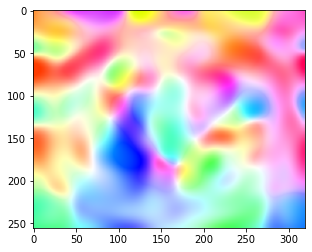

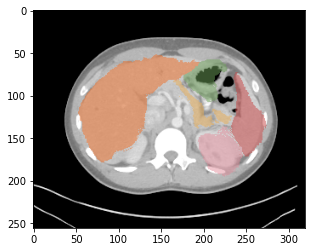

In [72]:
#obel.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255

fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()

with torch.no_grad():
    feat1 = obel(fixed.cuda())
    feat2 = obel(moving.cuda())

ssd_distance = correlation_layer(displace_range, feat2, feat1).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost,pred_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
dense_flow_fit = F.interpolate(pred_xy, scale_factor=4,mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()

warped_seg = F.grid_sample(fixed_seg.float().unsqueeze(1).cuda(),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

d1 = dice_coeff(moving_seg,warped_seg.squeeze(),9)
print("PDD-Student: ", d1,d1.mean())
d3 = dice_coeff(fixed_seg,moving_seg,9)
print("diff fixed, moving: ", d3, d3.mean())

#visualise
rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
plt.imshow(rgb)
plt.show()
rgb = overlaySegment(fixed.squeeze().t().flip(0),warped_seg.data.squeeze().t().flip(0),True)

### Seq training loop

In [73]:
seq.cuda().train()

optimizer = torch.optim.Adam(list(seq.parameters()),lr=0.00025)
disp_hw = 5
displace_range = 11

In [74]:
for pdx in range(epochs):
    rnd_train_idx = torch.randperm(train_set.size(0))
    
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    img_fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float()/255
    img_moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float()/255

    #feat_fixed = seq(img_fixed)
    #feat_moving = seq(img_moving)

    seg_fixed = segs[p_fix:p_fix+1,:,:].long().contiguous()
    seg_moving = segs[p_mov:p_mov+1,:,:].long().contiguous()
    
    label_moving = F.one_hot(seg_moving,num_classes=9).permute(0,3,1,2).float()
    _,C1,Hf,Wf = label_moving.size()
    label_moving = F.interpolate(label_moving,size=(H//4,Wf//4),mode='bilinear')
    label_fixed = F.one_hot(seg_fixed,num_classes=9).permute(0,3,1,2).float()
    label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
    # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
    # according to the corresponding discrete displacement pair
    label_moving_unfold = F.unfold(
        label_moving,(displace_range,displace_range),padding=disp_hw
    ).view(1,9,displace_range**2,-1)
    

    #forward path: pass both images through the network so that the weights appear in the computation graph
    # and will be updated
    feat_fixed = seq(img_fixed.cuda()).cpu()
    feat_moving = seq(img_moving.cuda()).cpu()
    # compute the cost tensor using the correlation layer
    ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
    
    # compute the MIN-convolution & probabilistic output with the given function
    soft_cost,disp_xy = meanfield(ssd_distance, img_fixed, displace_range, H//4, W//4)
    # loss computation:
    # compute the weighted sum of the shifted moving label versions 
    
    label_warped = torch.sum(soft_cost.t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
    # compute the loss as sum of squared differences between the fixed label representation and the "warped" labels
    label_distance1 = torch.sum(torch.pow(label_fixed.reshape(9,-1)-label_warped.reshape(9,-1),2),0)
    loss = label_distance1.mean()
    # perform the backpropagation and weight updates
    loss.backward()
    if (pdx+1)%grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer.step()
        optimizer.zero_grad()

### Seq Eval

CNN-Student:  tensor([0.7929, 0.7894, 0.4020, 0.0000, 0.8077, 0.6718, 0.3238, 0.0000]) tensor(0.4735)
diff fixed, moving:  tensor([0.5856, 0.8351, 0.0000, 0.0000, 0.6483, 0.6209, 0.4499, 0.0000]) tensor(0.3925)


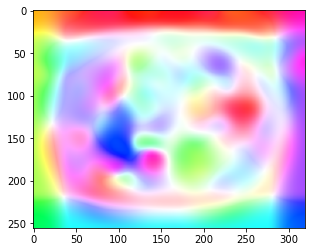

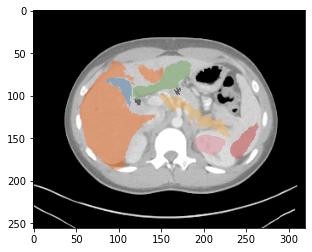

In [82]:
#seq.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed_img = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).float() / 255
moving_img = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).float() / 255

fixed_seg = segs[p_fix:p_fix+1,:,:].long().contiguous()
moving_seg = segs[p_mov:p_mov+1,:,:].long().contiguous()

with torch.no_grad():
    fixed_feat = seq(fixed_img.cuda())
    moving_feat = seq(moving_img.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost,disp_xy = meanfield(ssd_distance, fixed_img.unsqueeze(1), displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,scale_factor=4,mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),9)
print("CNN-Student: ", d1,d1.mean())
d3 = dice_coeff(fixed_seg,moving_seg,9)
print("diff fixed, moving: ", d3, d3.mean())
#visualise
rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
plt.imshow(rgb)
plt.show()
rgb = overlaySegment(fixed.squeeze().t().flip(0),warped_seg.data.squeeze().t().flip(0),True)

# Evaluation

CNN can actually warp the labels, Obelisk has some problems. Let's see if they can learn a teacher output in Experiment 2